## Transfer Learning using MNIST data
To illustrate the power and concept of transfer learning, we will train a CNN on just the digits 5,6,7,8,9.  Then we will train just the last layer(s) of the network on the digits 0,1,2,3,4 and see how well the features learned on 5-9 help with classifying 0-4.

Adapted from https://github.com/fchollet/keras/blob/master/examples/mnist_transfer_cnn.py

In [1]:
from __future__ import print_function
import tensorflow
import datetime
import keras
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from PIL import Image
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
%matplotlib inline


Using TensorFlow backend.
/home/u6975/.conda/envs/tensorflow-36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
################## set up some variables #################
#dir_path = "/Users/huynh/Desktop/256/ut-zap50k-images"
#resize_path = 'resize_img'
im = []

# set some parameters
batch_size = 300
num_classes = 7
epochs = 5

# set some more parameters
img_rows, img_cols = 50, 50
filters = 32
pool_size = 2
kernel_size = 5
img_channels = 1

#used to help some of the timing functions
now = datetime.datetime.now


In [3]:
# get the path to all pictures in im list. Comment out cuz we got it
#def get_image_paths(path, im):
#    listing = os.listdir(path)
#    count = 0
#    for item in listing:

#        if item == '.DS_Store':
#            continue
#        else:
#            if '.jpg' in listing[0]:
#                if count == 0:
#                    im += [path + '/' + i for i in listing]
#                    count += 1
#            else:         
#                get_image_paths(path + '/' + item, im)

#get_image_paths(dir_path, im)

In [5]:
# create resize_images. Comment out because we got it
#for path in imlist:
#    temp = Image.open(path)
#    temp = temp.resize((img_rows,img_cols))
#    temp = temp.convert('L')
#    fileName = path.split('/')[-1]
#    tempArr = fileName.split('-')
#    temp.save('/home/u6975/resize_img/' + tempArr[0] + '-' + tempArr[1], "JPEG")

In [3]:
################ function to train the model ##################
def train_model(model, x_train, x_test, y_train, y_test, num_classes, epochs, featureName):
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols,1)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    # checkpoint
    if featureName == 'Category':
        filepath="/home/u6975/models/" + featureName + ".best.hdf5"
    elif featureName == 'Gender':
        filepath="/home/u6975/models/" + featureName + ".best.hdf5"
    elif featureName == 'SubCategory':
        filepath="/home/u6975/models/" + featureName + ".best.hdf5"
    elif featureName == 'HeelHeight':
        filepath="/home/u6975/models/" + featureName + ".best.hdf5"
    elif featureName == 'Material':
        filepath="/home/u6975/models/" + featureName + ".best.hdf5"
        
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks_list,
              verbose=0,
              validation_data=(x_test, y_test))
    #print('Training time: %s' % (now() - t))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [33]:
def get_model(num_classes):
    ################ feature reducing layer ##############
    feature_layers = [
        Conv2D(filters, kernel_size,
               padding='valid',
               input_shape=(img_rows, img_cols,1)),
        Activation('relu'),
        Conv2D(filters, kernel_size),
        Activation('relu'),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.25),
        Flatten(),
    ]

    ############ classification layer ############
    classification_layers = [
        Dense(128),
        Activation('relu'),
        Dropout(0.5),
        Dense(num_classes),
        Activation('softmax')
    ]

    # We create our model by combining the two sets of layers as follows
    model = Sequential(feature_layers + classification_layers)
    return model

In [5]:
################# Needed function ##############
# filter df to the needed cols and modify the new df CID col
def get_df(filterString):
    df = pd.read_csv('meta-data-bin.csv')
    df1 = df.filter(regex='CID').join(df.filter(regex=filterString))

    for x in range(50025):
        df1.iloc[[x],[0]] = '/home/u6975/resize_img/' + df1.iloc[[x],[0]] + '.jpg'
    return df1

# join table and drop NaN
def join_drop(df, feature):
    df1 = pd.read_csv('meta-data.csv')
    df1 = df1.drop('CID', 1)
    df2 = df1.join(df)
    df2 = df2.dropna(subset=[feature])
    df2 = df2.filter(regex='CID').join(df.filter(regex=feature))
    df2 = df2[~df2['CID'].isin(['/home/u6975/resize_img/8029595-574.jpg'])]
    return df2

# make a matrix for flatten img
def make_matrix(df):    
    imlist1 = df['CID'].values.tolist()
    immatrix = np.array([np.array(Image.open(im2)).flatten() for im2 in imlist1])
    immatrix.astype(float)
    return immatrix

# make labels list
def make_label(df):
    temp = len(df.index)
    label1 = np.ones((temp,),dtype = int)
    for x in range(temp):
        for t in range(df.shape[1]):
            if df.get_value(x, t, takeable=True) == 1:
                label1[x] = t - 1
                break
    return label1

In [6]:
############ This part is for Gender ###############
# Men
# Women
# Boy
# Girl

# init some variables
feature = 'Gender'
num_classes = 4
epochs = 5

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [9]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
activation_5 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 42, 42, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14112)             0         
__________

In [ ]:
############ This part is for SubCategory ###############
# Oxfords
# Mid.Calf
# Heel
# Ankle
# Boot
# Loafers
# Slipper.Flats
# Boat.Shoes
# Flat
# Clogs.and.Mules
# Flats
# Sneakers.and.Athletic.Shoes
# Slipper.Heels
# Heels
# Athletic
# Prewalker
# Knee.High
# Prewalker.Boots
# Crib.Shoes
# Firstwalker
# Over.the.Knee

# init some variables
feature = 'SubCategory'
num_classes = 21
epochs = 5

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [12]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

x_train shape: (40019, 50, 50, 1)
40019 train samples
10005 test samples
Epoch 00000: val_acc improved from -inf to 0.69075, saving model to /home/u6975/models/SubCategory.best.hdf5
Epoch 00001: val_acc improved from 0.69075 to 0.73023, saving model to /home/u6975/models/SubCategory.best.hdf5
Epoch 00002: val_acc improved from 0.73023 to 0.74513, saving model to /home/u6975/models/SubCategory.best.hdf5
Epoch 00003: val_acc improved from 0.74513 to 0.77491, saving model to /home/u6975/models/SubCategory.best.hdf5
Epoch 00004: val_acc did not improve
Test score: 0.684641489489
Test accuracy: 0.771214392833


In [13]:
############ This part is for HeelHeight ###############
# 1in...1.3.4in, 
# 2in...2.3.4in, 
# Under.1in,
# Flat,
# 4in...4.3.4in,
# 3in...3.3.4in,
# 5in...over

# init some variables
feature = 'HeelHeight'
num_classes = 7
epochs = 5

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
activation_13 (Activation)   (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
activation_14 (Activation)   (None, 42, 42, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 14112)             0         
__________

In [14]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

x_train shape: (23974, 50, 50, 1)
23974 train samples
5994 test samples
Epoch 00000: val_acc improved from -inf to 0.56156, saving model to /home/u6975/models/HeelHeight.best.hdf5
Epoch 00001: val_acc improved from 0.56156 to 0.61228, saving model to /home/u6975/models/HeelHeight.best.hdf5
Epoch 00002: val_acc improved from 0.61228 to 0.62029, saving model to /home/u6975/models/HeelHeight.best.hdf5
Epoch 00003: val_acc improved from 0.62029 to 0.63697, saving model to /home/u6975/models/HeelHeight.best.hdf5
Epoch 00004: val_acc improved from 0.63697 to 0.65616, saving model to /home/u6975/models/HeelHeight.best.hdf5
Test score: 0.874347035154
Test accuracy: 0.656156156176


In [6]:
############ This part is for Category ###############
# Shoes
# Boots
# Sandals
# Slippers

# init some variables
feature = 'Category'
num_classes = 4
epochs = 5

# prepare data from dataset
df1 = get_df(feature)
df1 = join_drop(df1, feature)

# format them into expected data structure
new_matrix = make_matrix(df1)
new_label = make_label(df1)
new_model = get_model(num_classes)

# prepare data for training
data,Label = shuffle(new_matrix, new_label, random_state=2)
train_data = [data,Label]
(x, y) = (train_data[0], train_data[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 42, 42, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14112)             0         
__________

In [7]:
# train it
train_model(new_model, x_train, x_test, y_train, y_test, num_classes, epochs, feature)

x_train shape: (40019, 50, 50, 1)
40019 train samples
10005 test samples
Epoch 00000: val_acc improved from -inf to 0.83948, saving model to /home/u6975/models/Category.best.hdf5
Epoch 00001: val_acc improved from 0.83948 to 0.90035, saving model to /home/u6975/models/Category.best.hdf5
Epoch 00002: val_acc improved from 0.90035 to 0.90905, saving model to /home/u6975/models/Category.best.hdf5
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc improved from 0.90905 to 0.91824, saving model to /home/u6975/models/Category.best.hdf5
Test score: 0.234385060335
Test accuracy: 0.918240879584


In [66]:
def test_one(num_classes, modelPath, testImagePath):
    test_model = get_model(num_classes)

    # load weights
    test_model.load_weights(modelPath)
    # Compile model (required to make predictions)
    test_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    # this block is for a example classification
    numArr = Image.open(testImagePath)
    numArr = numArr.resize((img_rows,img_cols))
    numArr = numArr.convert('L')
    plt.imshow(numArr)

    xArr=[]
    xArr.append(numArr)

    numArr1 = np.array([np.array(tt).flatten() for tt in xArr])
    numArr1 = numArr1.astype(float)
    numArr1 /= 255
    numArr1 = numArr1.reshape(numArr1.shape[0], img_rows, img_cols, 1)

    somePredict = test_model.predict_classes(numArr1)
    somePredict = somePredict.tolist()
    endList = [0] * num_classes
    endList[somePredict[0]] = 1 
    return endList

def test_all(testImagePath):
    category = test_one(4, '/home/u6975/models/Category.best.hdf5', testImagePath)
    heelHeight = test_one(7, '/home/u6975/models/HeelHeight.best.hdf5', testImagePath)
    subCategory = test_one(21, '/home/u6975/models/SubCategory.best.hdf5', testImagePath)
    gender = test_one(4, '/home/u6975/models/Gender.best.hdf5', testImagePath)
    result = gender + category + heelHeight + subCategory
    return result

1/1 [==============================] - 0s
[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Gender.Men', 'Gender.Women', 'Gender.Boys', 'Gender.Girls', 'Category.Shoes', 'Category.Boots', 'Category.Sandals', 'Category.Slippers', 'HeelHeight.1in...1.3.4in', 'HeelHeight.2in...2.3.4in', 'HeelHeight.Under.1in', 'HeelHeight.Flat', 'HeelHeight.4in...4.3.4in', 'HeelHeight.3in...3.3.4in', 'HeelHeight.5in...over', 'SubCategory.Oxfords', 'SubCategory.Mid.Calf', 'SubCategory.Heel', 'SubCategory.Ankle', 'SubCategory.Boot', 'SubCategory.Loafers', 'SubCategory.Slipper.Flats', 'SubCategory.Boat.Shoes', 'SubCategory.Flat', 'SubCategory.Clogs.and.Mules', 'SubCategory.Flats', 'SubCategory.Sneakers.and.Athletic.Shoes', 'SubCategory.Slipper.Heels', 'SubCategory.Heels', 'SubCategory.Athletic', 'SubCategory.Prewalker', 'SubCategory.Knee.High', 'SubCategory.Prewalker.Boots', 'SubCategory.Crib.Shoes', 'SubCategory.Firstwalker', 'SubCategory.Over.the

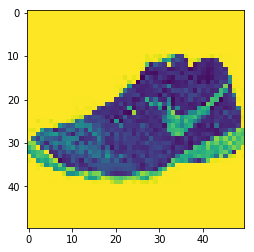

In [73]:
result = test_all('testImg1.jpg')
print(result)
# get all needed headers 
df = pd.read_csv('meta-data-bin.csv')
df1 = df.filter(regex='Category|HeelHeight|Gender')
headerList = df1.columns.values.tolist()
headerList = headerList[32:] + headerList[0:4] + headerList[25:32] + headerList[4:25]

# print the classifications of the image
for index, value in enumerate(result):
    if value == 1:
        print(headerList[index])